In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 数据

x_train.shape: (70, 2)
y_train.shape: (70, 1)


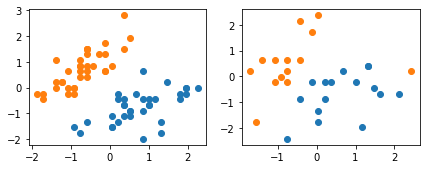

In [2]:
df = pd.read_csv("../data/iris.data", sep=",")
data = df.to_numpy()

x = data[:100, :2].astype(np.float)
y = np.zeros(100)
y[50:] = 1

n, m = x.shape
shuffle_idx = np.random.permutation(n)
x, y = x[shuffle_idx], y[shuffle_idx]

x_train, x_test = x[:70], x[70:]
y_train, y_test = y[:70], y[70:]

mu, std = np.mean(x_train, axis=0), np.std(x_train, axis=0)
x_train, x_test = (x_train - mu) / std, (x_test - mu) / std
y_train, y_test = y_train.reshape((-1, 1)), y_test.reshape((-1, 1))
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])
plt.show()

## 0. low-level with manual gradients

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def init_parameters():
    weights = torch.randn(2, 1, dtype=torch.float32, device=device)
    bias = torch.zeros(1, dtype=torch.float32, device=device)
    return weights, bias

def forward(x, weights, bias):
    linear = torch.add(torch.mm(x, weights), bias)
    predict_probas = torch.sigmoid(linear)
    return predict_probas

def predict_label(logits):
    predict_labals = torch.round(logits)
    return predict_labals

def cost(logits, y):
    cost = -(torch.mul(y, torch.log(logits)) + torch.mul(1-y, torch.log(1-logits)))
    return cost

def train(x, y, weights, bias, epochs, learning_rate=0.01):
    print(x.size())
    print(y.size())
    for epoch in range(epochs):
        predict_probas = forward(x, weights, bias)
        
        gw = torch.mm(x.transpose(0, 1), y-predict_probas)
        gb = torch.sum(y-predict_probas)
        
        weights += learning_rate * gw
        bias += learning_rate * gb
    
    return weights, bias

In [5]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

weights, bias = init_parameters()
weights, bias = train(x_train_tensor, y_train_tensor, weights, bias, epochs=10, learning_rate=0.01)
weights, bias

torch.Size([70, 2])
torch.Size([70, 1])


(tensor([[ 0.9255],
         [-1.2527]], device='cuda:0'),
 tensor([-0.0586], device='cuda:0'))

No handles with labels found to put in legend.


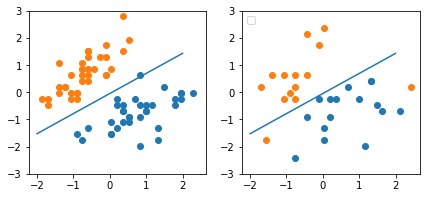

In [6]:
w, b = weights, bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].set_ylim([-3, 3])
ax[1].set_ylim([-3, 3])

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])

ax[1].legend(loc='upper left')
plt.show()

## 1. low-level with manual gradients

### 模型

In [7]:
class LogisticRegression():
    def __init__(self, n_features):
        self.n_features = n_features
        self.weights = torch.randn(2, 1, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
    
    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        probas = self._sigmoid(linear)
        return probas
    
    def backward(self, probas, y):
        cost = y - probas
        return cost
    
    def predict_label(self, x):
        probas = self.forward(x)
        labels = torch.round(probas)
        return labels
    
    def evaluate(self, x, y):
        labels = self.predict_label(x).float()
        accuracy = torch.sum((labels == y).float()) / y.size()[0]
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
         return -torch.sum(torch.mul(y, torch.log(proba)) + torch.mul((1-y), torch.log(1-proba)))
    
    def train(self, x, y, epochs, learning_rate=0.01):
        for epoch in range(epochs):
            # predict
            probas = self.forward(x)
            
            # gradient
            cost = self.backward(probas, y)
            ## gw = (y-logits)*x
            ## gb = (y-logits)
            gw = torch.mm(x.transpose(0, 1), cost)
            gb = torch.sum(cost)
            
            # update weights
            self.weights += learning_rate * gw
            self.bias += learning_rate * gb
            
            # log
            print('Epoch: %03d' % (epoch+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % self._logit_cost(y, self.forward(x)))

### train

In [8]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

logisticRegression = LogisticRegression(n_features=2)
logisticRegression.train(x_train_tensor, y_train_tensor, epochs=10, learning_rate=0.01)

print('\nModel parameters:')
print('  Weights: %s' % logisticRegression.weights)
print('  Bias: %s' % logisticRegression.bias)

Epoch: 001 | Train ACC: 0.714 | Cost: 41.687
Epoch: 002 | Train ACC: 0.814 | Cost: 33.102
Epoch: 003 | Train ACC: 0.900 | Cost: 27.052
Epoch: 004 | Train ACC: 0.929 | Cost: 22.733
Epoch: 005 | Train ACC: 0.943 | Cost: 19.581
Epoch: 006 | Train ACC: 0.957 | Cost: 17.217
Epoch: 007 | Train ACC: 0.957 | Cost: 15.394
Epoch: 008 | Train ACC: 0.986 | Cost: 13.951
Epoch: 009 | Train ACC: 0.986 | Cost: 12.783
Epoch: 010 | Train ACC: 0.986 | Cost: 11.819

Model parameters:
  Weights: tensor([[ 1.7948],
        [-0.9731]], device='cuda:0')
  Bias: tensor([-0.0046], device='cuda:0')


### Evaluating the Model

In [9]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = logisticRegression.evaluate(x_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.67%


No handles with labels found to put in legend.


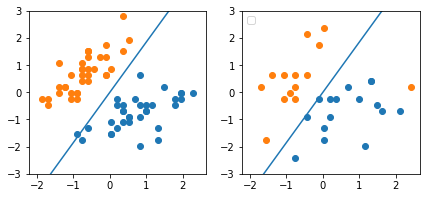

In [10]:
w, b = logisticRegression.weights, logisticRegression.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].set_ylim([-3, 3])
ax[1].set_ylim([-3, 3])

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])

ax[1].legend(loc='upper left')
plt.show()

## 2. low-level with autograd

In [11]:
class LogisticRegression2():
    def __init__(self, n_features):
        self.n_features = n_features
        self.weights = torch.randn(2, 1, dtype=torch.float32, device=device, requires_grad=True)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device, requires_grad=True)
    
    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        probas = self._sigmoid(linear)
        return probas
    
    def backward(self, probas, y):
        cost = y - probas
        return cost
    
    def predict_label(self, x):
        probas = self.forward(x)
        labels = torch.round(probas)
        return labels
    
    def evaluate(self, x, y):
        labels = self.predict_label(x).float()
        accuracy = torch.sum((labels == y).float()) / y.size()[0]
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
         return -torch.sum(torch.mul(y, torch.log(proba)) + torch.mul((1-y), torch.log(1-proba)))
    
    def train(self, x, y, epochs, learning_rate=0.01):
        for epoch in range(epochs):
            # predict
            probas = self.forward(x)
            
            # gradient
            cost = self._logit_cost(y, probas)
            cost.backward()
            
            # update weights
            ## 如果是自动求导，则不能直接复制
            ## self.weights -= learning_rate * self.weights.grad ## ERROR
            tmp = self.weights.detach()
            tmp -= learning_rate * self.weights.grad
            
            tmp = self.bias.detach()
            tmp -= learning_rate * self.bias.grad
            
            # reset gradients to zero
            self.weights.grad.zero_()
            self.bias.grad.zero_()
            
            # log
            print('Epoch: %03d' % (epoch+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % self._logit_cost(y, self.forward(x)))

In [12]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

logr = LogisticRegression2(n_features=2)
logr.train(x_train_tensor, y_train_tensor, epochs=10, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % logr.weights)
print('  Bias: %s' % logr.bias)

Epoch: 001 | Train ACC: 1.000 | Cost: 2.428
Epoch: 002 | Train ACC: 1.000 | Cost: 2.249
Epoch: 003 | Train ACC: 1.000 | Cost: 2.101
Epoch: 004 | Train ACC: 1.000 | Cost: 1.976
Epoch: 005 | Train ACC: 1.000 | Cost: 1.868
Epoch: 006 | Train ACC: 1.000 | Cost: 1.773
Epoch: 007 | Train ACC: 1.000 | Cost: 1.690
Epoch: 008 | Train ACC: 1.000 | Cost: 1.615
Epoch: 009 | Train ACC: 1.000 | Cost: 1.547
Epoch: 010 | Train ACC: 1.000 | Cost: 1.486

Model parameters:
  Weights: tensor([[ 3.7354],
        [-3.6574]], device='cuda:0', requires_grad=True)
  Bias: tensor([0.1855], device='cuda:0', requires_grad=True)


In [13]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = logr.evaluate(x_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 93.33%


No handles with labels found to put in legend.


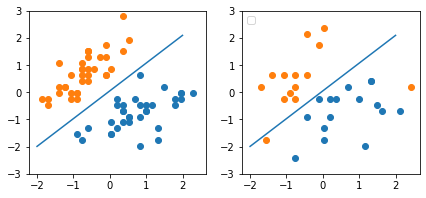

In [14]:
w, b = logr.weights, logr.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].set_ylim([-3, 3])
ax[1].set_ylim([-3, 3])

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])

ax[1].legend(loc='upper left')
plt.show()

## 3. high-level with autograd

In [15]:
class LogisticRegression3(torch.nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression3, self).__init__()
        self.linear = torch.nn.Linear(n_features, 1)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
    
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        
        return probas

model = LogisticRegression3(n_features=2).to(device)

### cost

In [16]:
cost_fn = torch.nn.BCELoss(reduce="sum")

D:\AdvanceIDE\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### optimizer

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [18]:
def accuracy(y, probas):
    predict_labels = torch.round(probas)
    acc = torch.sum((y == predict_labels).float()) / y.size()[0]
    return acc

epochs = 10

x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

for epoch in range(epochs):
    # logits
    out = model(x_train_tensor)
    
    # gradient
    cost = cost_fn(out, y_train_tensor)
    optimizer.zero_grad()
    cost.backward()
    
    # update
    optimizer.step()
    
    # log
    probas = model(x_train_tensor)
    acc = accuracy(y_train_tensor, probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % cost_fn(probas, y_train_tensor))
    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)

Epoch: 001 | Train ACC: 1.000 | Cost: 0.690
Epoch: 002 | Train ACC: 1.000 | Cost: 0.688
Epoch: 003 | Train ACC: 1.000 | Cost: 0.685
Epoch: 004 | Train ACC: 1.000 | Cost: 0.682
Epoch: 005 | Train ACC: 1.000 | Cost: 0.680
Epoch: 006 | Train ACC: 1.000 | Cost: 0.677
Epoch: 007 | Train ACC: 1.000 | Cost: 0.675
Epoch: 008 | Train ACC: 1.000 | Cost: 0.672
Epoch: 009 | Train ACC: 1.000 | Cost: 0.669
Epoch: 010 | Train ACC: 1.000 | Cost: 0.667

Model parameters:
  Weights: Parameter containing:
tensor([[ 0.0361, -0.0364]], device='cuda:0', requires_grad=True)
  Bias: Parameter containing:
tensor([-0.0014], device='cuda:0', requires_grad=True)


### Evaluating the Model

In [19]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(x_test_tensor)
test_acc = accuracy(y_test_tensor, pred_probas)

print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 93.33%


No handles with labels found to put in legend.


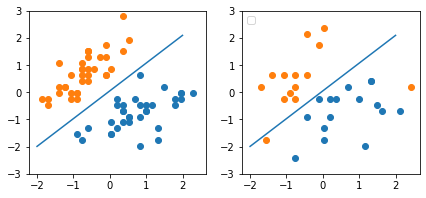

In [20]:
w, b = logr.weights, logr.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].set_ylim([-3, 3])
ax[1].set_ylim([-3, 3])

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])

ax[1].legend(loc='upper left')
plt.show()